In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from data.BCS_casadi import BCS_model
from data.plot_result import PlotResult
from data.bcs_envelope import BcsEnvelope
import seaborn as sns
from data.PinnPredictor import PinnPredictor

predictor=PinnPredictor("pinn_models/data_model02")
sns.set_theme()

# steady-state conditions
xss = np.vstack([8311024.82175957, 2990109.06207437,
                0.00995042241351780, 50., 50.])
nx = 5
nu = 2
ny = 2

uss = np.vstack([50., 50.])
yss = np.vstack([6000142.88550200, 592.126490003812])
# output scale factor

Ts = 2  # sampling time
# --------------------------------------------------------------------------
# constraints on inputs
# --------------------------------------------------------------------------
umin = np.vstack([35, 0])    # lower bounds of inputs
umax = np.vstack([65, 100])    # upper bounds of inputs
# maximum variation of input moves: [0.5 Hz/s; 0.5 #/s]
dumax = Ts*np.vstack([0.5, 0.5])
# ----------------------------------------------
# ------Normalização através dos pesos----------
q = np.hstack([100, 1]) / (yss**2)  # weights on controlled variables
q = np.hstack([1e6, 1e8]) / (yss**2)  # weights on controlled variables
r = np.array([100, 1]) / (uss.T**2)  # weights on control actions
qu = 1000 / (uss[1]**2)

print("Instancia BCS")
bcs_init = [nu, nx, ny, Ts, umin, umax, dumax]

bcs = BCS_model(nu, nx, ny, Ts, umin, umax, dumax)

# --------------------------------------------------------------------------
# Initial condition (preferred steady-state)
# --------------------------------------------------------------------------
uk_1 = np.vstack([50., 50.])  # manipulated variable
print("Initial states")
print("Pbh, Pwh, q, df, dzc")
x0 = np.vstack([8311024.82175957, 2990109.06207437,
               0.00995042241351780, 50., 50.])  # state variables
print("Initial control")
print("f, zc")

try:
    print(bcs.desnorm_x(bcs.F(x0=bcs.norm_x(x0), p=uss)['xf']))
except Exception as e:
    print("An exception was raised here:")
    print(e)

pm = 2e6   # pressão da manifold

# Regiao de operação
hlim = bcs.envelope.Hlim(x0[2]*3600)
ymin = np.vstack([yss[0], min(hlim)])  # Pressao de intake e  Downtrhust
ymax = np.vstack([xss[0], max(hlim)])  # Pressao de intake e  Uptrhust
# ymin(2,1) = min(hlim); # Downtrhust
# ymax(2,1) = max(hlim); # Uptrhust
xpk = xss
ysp = yss
Vruido = ((0.01/3)*np.diag(yss[:, 0]))**2

# # Parameters: initial states, du,utg, u0,ysp


Yk = yss
Xk = xss.reshape((xss.shape[0], 1))
Ysp = yss
HLim = np.vstack([ymax[1], ymin[1]])
PINLim = np.vstack([ymax[0], ymin[0]])
rows = []

#Initial conditions for PINN predictions
xi=xss[0:2].T #bar
pr=126e5
pm=20e5
bcs.update_BCS(pm,pr)
ui=np.vstack([uss,pm,pr]).T
Ui,Xi=predictor.start_dataset(ui,xi)
yi,x_pinn=predictor.predict_pinn(Ui,Xi)

X_Pinn,X_m=[],[]
X_Pinn.append([0]+x_pinn[:,0].tolist())
X_m.append([0]+xss[0:3,0].tolist())

# Simulation Loop -------------------------------- ------------------------------
tsim = 1.    # minutes
nsim = int(60*tsim/Ts)   # number of steps
uk = np.zeros((bcs.nu, int(nsim)))


for k in range(nsim):
    print("Iteração:", k)
    tsim = k*Ts/60

    # changes on inputs
    if tsim == 0.4:
        pm=27e5
        bcs.update_BCS(pm,pr)

    elif tsim == 0.8:
        uk_1 = np.vstack([65., 50.])
    elif tsim == 2.5:
        pr=100e5
        bcs.update_BCS(pm,pr)

    elif tsim == 4.:
        uk_1 = np.vstack([65., 85.])
        
    elif tsim == 5.5:
        pm=23e5
        bcs.update_BCS(pm,pr)
    
    ui=np.vstack([uk_1,pm,pr]).T
    Ui,Xi=predictor.update_inputs(yi,ui,Ui,Xi)
    yi,x_pinn=predictor.predict_pinn(Ui,Xi)

    # ## Limite Up e Downthrust
    hlim = bcs.envelope.Hlim(xpk[2]*3600)
    ymin[1, 0] = min(hlim)
    ymax[1, 0] = max(hlim)
    uk[:, k:k+1] = uk_1

    # Plant
    xpk = bcs.integrator_ode(x0, uk_1)
    

    #  Nominal Model
    x0 = xpk
    ypk = bcs.eq_medicao(x0)
    
    ruido = 5
    # +np.random.multivariate_normal((0,0), Vruido).reshape((bcs.ny,1)) # ruido -> 3x a 5x
    ypk = ypk
    Yk = np.concatenate((Yk, ypk), axis=1)
    Ysp = np.concatenate((Ysp, ysp), axis=1)
    HLim = np.concatenate((HLim, np.vstack([ymax[1], ymin[1]])), axis=1)
    PINLim = np.concatenate((PINLim, np.vstack([ymax[0], ymin[0]])), axis=1)
    Xk = np.concatenate((Xk, x0.reshape((x0.shape[0], 1))), axis=1)
    X_Pinn.append([tsim]+x_pinn[:,0].tolist())
    X_m.append([tsim]+xpk[0:3,0].tolist())
    
df_pinn = pd.DataFrame(X_Pinn, columns=['t','pbh','pwh','q'])
df_mod = pd.DataFrame(X_m, columns=['t','pbh','pwh','q'])

/home/taniel/anaconda3/envs/BCS2/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Dados carregados
Loading model from pinn_models/data_model02


Instancia BCS
Initial states
Pbh, Pwh, q, df, dzc
Initial control
f, zc
[8.31102e+06, 2.99011e+06, 0.00995042, 50, 50]
Iteração: 0

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

Iteração: 1
Iteração: 2
Iteração: 3
Iteração: 4
Iteração: 5
Iteração: 6
Iteração: 7
Iteração: 8
Iteração: 9
Iteração: 10
Iteração: 11
Iteração: 12
Iteração: 13
Iteração: 14
Iteração: 15
Iteração: 16
Iteração: 17
Iteração: 18
Iteração: 19
Iteração: 20
Iteração: 21
Iteração: 22
Iteração: 23
Iteração: 24
Iteração: 25
Iteração: 26
Iteração: 27
Iteração: 28
Iteração: 29


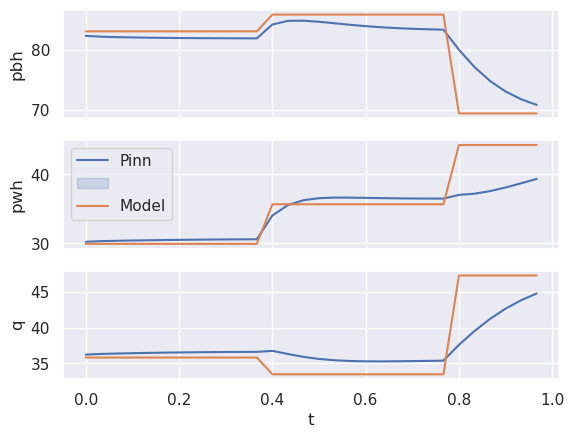

In [2]:
df_pinn = pd.DataFrame(X_Pinn, columns=['t','pbh','pwh','q'])
df_mod = pd.DataFrame(X_m, columns=['t','pbh','pwh','q'])
df_mod['q']=df_mod['q']*3600
df_pinn['q']=df_pinn['q']*3600
df_mod['pbh']=df_mod['pbh']/1e5
df_pinn['pbh']=df_pinn['pbh']/1e5
df_mod['pwh']=df_mod['pwh']/1e5
df_pinn['pwh']=df_pinn['pwh']/1e5

# print(df_pinn.head())
# print(df_mod.head())
fig_res, axes = plt.subplots(3, 1)
sns.lineplot(data=df_pinn, x='t', y='pbh', ax=axes[0], legend="full")
sns.lineplot(data=df_mod, x='t', y='pbh', ax=axes[0],legend="full")
g1=sns.lineplot(data=df_pinn, x='t', y='pwh', ax=axes[1])
sns.lineplot(data=df_pinn, x='t', y='q', ax=axes[2])
g2=sns.lineplot(data=df_mod, x='t', y='pwh', ax=axes[1])
sns.lineplot(data=df_mod, x='t', y='q', ax=axes[2])
axes[0].set(xlabel=None)
axes[1].set(xlabel=None)
axes[0].set_xticklabels([])
axes[1].set_xticklabels([])
g1.set_label("Pinn")#  legend(label="pinn")
g2.set_label("Phenomena")
#print(g.set_label["text"])
g1.legend(loc='upper left',labels=["Pinn",'',"Model"])

# plt.legend(labels=["Pinn","Model"])


NameError: name 'sns' is not defined

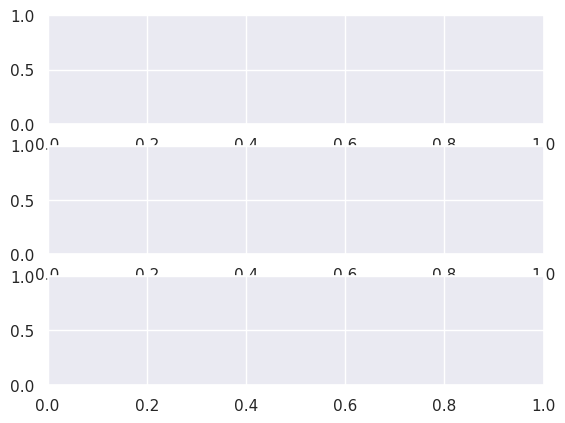

In [3]:
grafico = PlotResult(bcs.Ts)
grafico.plot_pinn_model(df_pinn,df_mod)